# Using physics informed neural networks (PINNs) to predict linear elasticity 

Motivated by the Github Repo Jungang(Gordon) Chen ----- Using PINN to a continuum mechanincs problem: 2D Linear elasticity.  
[PINN_Solver_SolidMechanics_stack.ipynb](https://github.com/jungangc/PINN-for-solid-mechanics/blob/main/PINN_Solver_SolidMechanics_stack.ipynb)

# Workflow

Physics-Informed Neural Networks (PINNs) for Linear Elasticity:

1. ***--> Material Parameters and Domain Definition:***   

Let the domain Ω ⊂ ℝ² be defined as: **Ω** = [𝑥min, 𝑥max] × [𝑦min, 𝑦max]  

**-> Material constants:**  
Young’s Modulus: 𝐸 = 4 × (10^11) / 3  
Poisson’s Ratio: 𝜈 = 1 / 3  

**-> Lamé parameters:**   
**λ** = EV / (1+ν)(1−2ν)  
**μ** = E / 2(1+ν)  
​ 

2. ***--> Exact Displacement and Force:***   

**Displacement:**   

The displacement field u(x, y) is defined as: u(x,y) = {u_x, u_y}.  
​
And the Prescribed displacement field is as follows:  
  
U_x = Cos(2πx) * sin(πy)  
U_y = (Sin(πx) * Q ) / (4 (y^4))  , Q = Applied Load 
 
**Strain tensor:**  

**𝜀** = 1/2 * (∇u + ∇u_Transposed), Which  is a symmetric tensor capturing the local deformation, excluding rigid-body rotations, ∇u -- Gradient (i.e., Jacobian Matrix) of displacement field.    


**Stress (Hooke’s Law, i.e.,  Cauchy stress tensor):**  

**σ** = λ⋅tr(ε)⋅I + 2μ⋅ε   

2μ⋅ε --- The deviatoric part (shear response), I -- Identity Matrix, tr(ε) represents volumetric strain.   


**Governing PDE (Navier-Cauchy Equilibrium equation):** ∇ . 𝜎 + f = 0 (also called the **linear momentum balance in the absence of inertia**)  

Force is derived by plugging  𝑢 into the equation and computing: f =−∇ ⋅ σ  

∇⋅σ: divergence of the stress tensor. It gives the net internal force per unit volume acting at a point due to internal stresses. 
f:  body force vector (due to external applied load) per unit volume.   

3. ***--> PINN Computation Strategy***  

**Loss functions (x4) include:**  

**PDE residual loss:**  

Equilibrium Residuals (Loss_PDE_1): How much is the 'Navier-Cauchy Equilibrium equation' being violated at each point    
Constitutive Residuals (Loss_PDE_2): How much is the 'Hooke’s Law' being violated at each point.  

**BCs residual loss:**   

Boundary Conditions Residuals (x2) : How much are the 'Boundary conditions, i.e., for Neumann and for Dirichlet' being violated at each point.  
 
4.  ***--> Total Loss and Training:***  

**Total Loss** = PDE residual loss + BCs residual loss  
Minimize Total Loss using:  
> Adam optimizer   
>BFGS-B optimize

5. ***--> Evaluation:***  
Error map, Loss evolution etc. 



# Required Libraries

In [89]:
import tensorflow as tf
import numpy as np
from pyDOE2 import lhs  # a package used for Latin Hypercube Sampling (LHS) — a way of picking points that evenly spread out over a region, 
#good for sampling training points. LHS is like scattering seeds evenly in a garden so every patch gets a seed — it avoids clumping points together.

# Precision Setting
for more accurate computations.

In [131]:
# Set data type
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE) # to confer  double precision for more accurate computations, backend Dtype is set to float64.

# Setting-up Boundaries and Material-specific constants

In [ ]:
# constants & model parameters
pi = tf.constant(np.pi, dtype=DTYPE)
E = tf.constant(4e11/3, dtype=DTYPE)                # Young's modulus. roughly 133 GPa, a realistic value for engineering materials.
v = tf.constant(1/3, dtype=DTYPE)                   # Poisson's ratio. ν = 1/3 is typical for metals (e,g., steel is around 0.3).
E = E/1e11                                          # Normalize Young's modulus to 1e11 for better numerical stability
                                                    # E is set to 4e11/3, which is a common value for materials like concrete or steel, and then normalized by dividing by 1e11.

# Lamé parameters 
lmda = tf.constant(E*v/(1-2*v)/(1+v), dtype=DTYPE)  # linear elasticity theory, specifically Hooke’s Law for isotropic materials in 2D/3D:λ helps model volumetric expansion or compression under stress.
mu = tf.constant(E/(2*(1+v)), dtype=DTYPE)          # shear modulus,describes  deformations under shear stress.y, the stress-strain relations use λ and μ to connect displacements (u) to stresses (σ).

# viscosity = .01/pi
Q = tf.constant(4.0, dtype=DTYPE)                   # a known distributed force (body force), controls the strength of the force applied to the system.

# Dirichlet boundary Conditions. Floating-point numbers are used to define the boundaries of the domain. xmin, xmax, ymin, ymax define the rectangular region where the PDE is solved.
xmin = 0.0
xmax = 1.0
ymin = 0.0
ymax = 1.0

# Define Exact Force and Displacements
To evaluate PINN's performance and accuracy. The derivation of the force equations can be found 'Body force Derivation' file at 'Mathematical explanations' folder.

1. **Exact Displacement (u)**: 'Cos(2πx)sin(πy)', exact displacement in the x-direction  for a given point (x, y) in the domain. Then a normalized transformed coordinate alternative is tried. same for the displacement in the y direction 'Sin(πx)Q/4y^4'  
2. **Exact Force(f)**: the exact force in the x-direction for a given point (x, y) in the domain. Derived by applying the Navier equations (idea: Momentum conservation) describing equilibrium of a deformable body.

3. **The Navier equations** for the displacement field u are: ∇⋅(σ) + ρb = 0 . where: σ is the Cauchy stress tensor, ρ is the mass density, and b is the body force vector.   
In linear elasticity, the Cauchy stress tensor is related to the displacement field through the Hooke's law, σ = λ(∇⋅u)I + 2μE. Where,  
λ and μ are Lamé parameters (material properties)  
I is the identity tensor  
E is the infinitesimal strain tensor, which is the symmetric part of the gradient of the displacement field: E = 1/2 (∇u + (∇u)ᵀ). The antisymmetric part corresponds to rigid body rotations which do not produce strain (no deformation).
  
4. Substituting Hooke's law into the Navier equation and assuming no body forces, we obtain:  (λ + 2μ)∇(∇⋅u) - μ∇×(∇×u) = 0. This equation represents a vector differential equation for the displacement field. It can be further simplified using vector identities, resulting in: (λ + 2μ)∇(∇⋅u) - μ∇×(∇×u) = 0   or   ∇⋅(σ) + ρb = 0



In [133]:
def u_x_exact(x, y):
    u_x_assigned = tf.cos(2*pi*x) * tf.sin(pi*(y))                                         
    # utemp = tf.cos(2*pi*(x-xmin)/(xmax-xmin)) * tf.sin(pi*(y-ymin)/(ymax-ymin))    
    return u_x_assigned
def u_y_exact(x, y):
    u_y_assigned = tf.sin(pi*x) * Q / 4 * tf.pow(y,4)                                         
    # utemp = tf.sin(pi*(x-xmin)/(xmax-xmin)) * Q/4*tf.pow((y-ymin)/(ymax-ymin),4)
    return u_y_assigned
def f_x_exact(x,y):
    f_x = 1.0*(-4*tf.pow(pi,2)*tf.cos(2*pi*x)*tf.sin(pi*y)+pi*tf.cos(pi*x)*Q*tf.pow(y,3))+\
    0.5*(-9*tf.pow(pi,2)*tf.cos(2*pi*x)*tf.sin(pi*y)+pi*tf.cos(pi*x)*Q*tf.pow(y,3))           
    # gtemp = 1.0*(-4*tf.pow(pi,2)*tf.cos(2*pi*(x-xmin)/(xmax-xmin))*tf.sin(pi*(y-ymin)/(ymax-ymin))+pi*tf.cos(pi*(x-xmin)/(xmax-xmin))*Q*tf.pow((y-ymin)/(ymax-ymin),3))+\
    # 0.5*(-9*tf.pow(pi,2)*tf.cos(2*pi*(x-xmin)/(xmax-xmin))*tf.sin(pi*(y-ymin)/(ymax-ymin))+pi*tf.cos(pi*(x-xmin)/(xmax-xmin))*Q*tf.pow((y-ymin)/(ymax-ymin),3))
    return f_x
def f_y_exact(x,y):
    f_y = lmda*(3*tf.sin(pi*x)*Q*tf.pow(y,2)-2*tf.pow(pi,2)*tf.sin(2*pi*x)*tf.cos(pi*y))+\
            mu*(6*tf.sin(pi*x)*Q*tf.pow(y,2)-2*tf.pow(pi,2)*tf.sin(2*pi*x)*tf.cos(pi*y)-tf.pow(pi,2)*tf.sin(pi*x)*Q*tf.pow(y,4)/4)
    # gtemp = lmda*(3*tf.sin(pi*(x-xmin)/(xmax-xmin))*Q*tf.pow((y-ymin)/(ymax-ymin),2)-2*tf.pow(pi,2)*tf.sin(2*pi*(x-xmin)/(xmax-xmin))*tf.cos(pi*(y-ymin)/(ymax-ymin)))+\
    #     mu*(6*tf.sin(pi*(x-xmin)/(xmax-xmin))*Q*tf.pow((y-ymin)/(ymax-ymin),2)-2*tf.pow(pi,2)*tf.sin(2*pi*(x-xmin)/(xmax-xmin))*tf.cos(pi*(y-ymin)/(ymax-ymin))-tf.pow(pi,2)*tf.sin(pi*(x-xmin)/(xmax-xmin))*Q*tf.pow((y-ymin)/(ymax-ymin),4)/4)
    return f_y

# Neumann & Dirichlet Boundary condition
In linear elasticity, the Neumann boundary condition prescribes the traction force (stress vector) on the surface of an object. I.e, we specify the stress vector acting on the boundary, rather than the displacement itself, which is known as a **Dirichlet condition**. The Neumann condition is also referred to as a **"natural" boundary condition** because it can be directly incorporated into the variational formulation of the problem. The derivation of Neumann boundary condition for the specific case can be found 'Mathematical Explanation' folder.

In [134]:
# Define boundary conditions at top 
def Neumann_BC(x, y):
    return (lmda+2*mu)*Q*tf.sin(pi*x)
    # return (lmda+2*mu)*Q*tf.sin(pi*(x-xmin)/(xmax-xmin))

### 2. Generate a set of collocation points  
**collocation points:**  specific locations (usually in the domain of a function or equation) where we enforce the approximate solution to exactly satisfy the governing equation.  
**->** the domain as a **2D rectangle** (like a trampoline frame).  
**->** Top: Stress is applied (like pressing down with a hand).  
**->** Bottom: Held tightly (no displacement).  
**->** Left & Right: Sliders or rollers—no vertical movement and no stress (imagine frictionless walls).  
**->** By setting these conditions, we teach the network how to behave at the edges while learning the physics inside.



**Data Points**

In [135]:
# Set number of data points
# N_0 = 50
N_bound = 50            # 50 points on each boundary
N_r = 1000              # 1000 residual points inside the domain

# Lower bounds
lb = tf.constant([xmin, ymin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

1. **Upper-Lower Boundary**

In [136]:
# Boundary points #
# Top boundary points
x_up = lhs(1,samples=N_bound,random_state=123)   # Latin Hypercube Sampling (LHS) to get 50 points in 1D (x-direction) between 0 and 1.
x_up = xmin + (xmax-xmin)*x_up                   # Maps these points to the actual x-range of the domain.
y_up = np.empty(len(x_up))[:,None]               # [:, None] reshapes the array to have shape (N_bound, 1).
y_up.fill(ymax)                                  # Creates an array of the same length as x_up, filled with the maximum y-value (ymax).

# Initialize Placeholder for Boundary Datas
disp_up = np.empty([len(x_up),2])                # a (50, 2) array meant to store displacement data at the top edge (for u_x and u_y).

# Fill the boundary data with the values of the external functions u_x and u_y at the boundary points.
disp_up[:,0,None] = u_x_exact(x_up, y_up)
disp_up[:,1,None] = u_y_exact(x_up, y_up)
x_up_train = np.hstack((x_up, y_up))             # as input to the PINN for training the boundary conditions.
 
Dirichlet_up_train = np.zeros([len(x_up),1])     # Initialize Dirichlet boundary condition at the top boundary to zero
Neumann_up_train = Neumann_BC(x_up, y_up)        # computes the Neumann BC (traction) in the y-direction at the top boundary

x_low = lhs(1,samples=N_bound,random_state=123)
x_low = xmin + (xmax-xmin)*x_low
y_low = np.empty(len(x_low))[:,None]
y_low.fill(ymin)                                  # Creates an array of the same length as x_lo, filled with the minimum y-value (ymin).

# Initialize Placeholder for Boundary Data
disp_low = np.empty([len(x_low),2])
disp_low[:,0, None] = u_x_exact(x_low, y_low)
disp_low[:,1, None] = u_y_exact(x_low, y_low)
x_low_train = np.hstack((x_low, y_low))

# Initialize Dirichlet boundary condition at the bottom boundary to zero and Neumann boundary condition does not apply at the bottom boundary.
Dirichlet_x_low_train = np.zeros([len(x_low),1])
Dirichlet_y_low_train = np.zeros([len(x_low),1])

print(disp_up.shape)
print(disp_low.shape)

(50, 2)
(50, 2)


2. **Right-Left Boundary**

In [137]:
y_right = lhs(1,samples=N_bound,random_state=123)
y_right = ymin + (ymax-ymin)*y_right
x_right = np.empty(len(y_right))[:,None]
x_right.fill(xmax)

disp_right = np.empty([len(x_right),2])
disp_right[:,0, None] = u_x_exact(x_right, y_right)
disp_right[:,1, None] = u_y_exact(x_right, y_right)

x_right_train = np.hstack((x_right, y_right)) 
Dirichlet_right_train = np.zeros([len(x_right),1])                  # meaning no vertical movement. (dirichlet condition)
Neumann_right_train = np.zeros([len(x_right),1])                    # traction-free or stress-free condition (Neumann BC)

y_left = lhs(1,samples=N_bound,random_state=123)
y_left = ymin + (ymax-ymin)*y_left
x_left = np.empty(len(y_left))[:,None]
x_left.fill(xmin)

disp_left = np.empty([len(x_left),2])
disp_left[:,0, None] = u_x_exact(x_left, y_left)
disp_left[:,1, None] = u_y_exact(x_left, y_left)

x_left_train = np.hstack((x_left, y_left))
Dirichlet_left_train = np.zeros([len(x_left),1])
Neumann_left_train = np.zeros([len(x_left),1])

print(disp_right.shape)
print(disp_left.shape)

(50, 2)
(50, 2)


**Collocatio points: Boundaries**  

Boundary conditions are applied!

In [138]:
# Combine all boundary data into a single training set
Boundary_train = np.concatenate((x_up_train, x_low_train, x_right_train, x_left_train))
Boundary_list = [x_up_train, x_low_train, x_right_train, x_left_train]

Dirichlet_x_train = np.concatenate((Dirichlet_up_train, Dirichlet_x_low_train))
Dirichlet_y_train = np.concatenate((Dirichlet_y_low_train, Dirichlet_right_train, Dirichlet_left_train))
Neumann_xx_train = np.concatenate((Neumann_right_train, Neumann_left_train))
Neumann_yy_train = Neumann_up_train

print( "The boundary data points, Dirichlet boundary data points (for x & y), Neumann boundary data points (for x & y):",  Boundary_train.shape, Dirichlet_x_train.shape, Dirichlet_y_train.shape, 
      Neumann_xx_train.shape, Neumann_yy_train.shape)

The boundary data points, Dirichlet boundary data points (for x & y), Neumann boundary data points (for x & y): (200, 2) (100, 1) (150, 1) (100, 1) (50, 1)


3. **Collocation points: Grid**

In [139]:
# Generate residual points in the domain using Latin Hypercube Sampling
grid_pt = lhs(2, N_r)

# Rescale the grid points to fit within the defined domain
grid_pt[:,0] = xmin + (xmax-xmin)*grid_pt[:,0]
grid_pt[:,1] = ymin + (ymax-ymin)*grid_pt[:,1]

# Separate x and y Coordinates
x_displacement_grid = grid_pt[:,0]
y_displacement_grid = grid_pt[:,1]

## compute the body forces at each collocation point using the force functions defined earlier.
# ff_x = np.asarray([ f_x_ext(xf[j],yf[j]) for j in range(len(yf))])
# ff_y = np.asarray([ f_y_ext(xf[j],yf[j]) for j in range(len(yf))])
# f_x_train = ff_x
# f_y_train = ff_y

# Combine Coordinates
Residual_train = np.hstack((x_displacement_grid[:,None], y_displacement_grid[:,None]))

print("The residual training data points:", Residual_train.shape)   

The residual training data points: (1000, 2)


In [140]:
import numpy as np

# Combine along rows
combined = np.concatenate([Boundary_train, Residual_train], axis=0)

# Save as CSV
np.savetxt("combined_dataset.csv", combined, delimiter=",")
print("Dataset saved as combined_dataset.csv")
print("Total data points:", combined.shape[0])

Dataset saved as combined_dataset.csv
Total data points: 1200


Next, we illustrate the collocation points (red circles) and the positions where the boundary and initial conditions will be enforced (color indicates value).

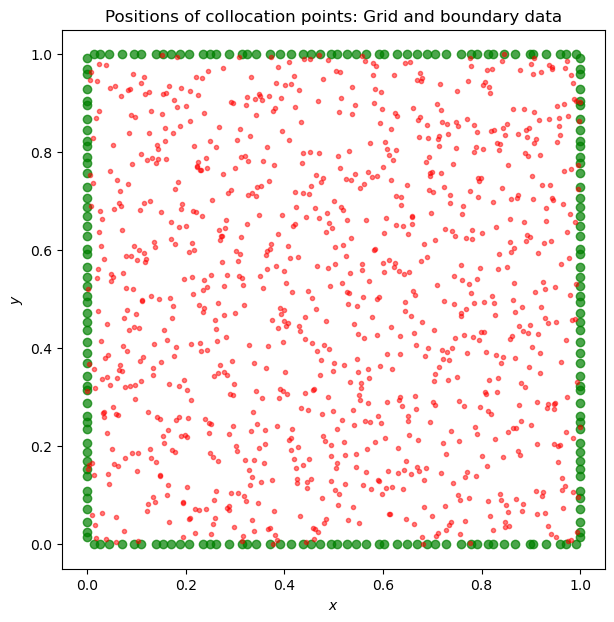

In [141]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7))
plt.scatter(Boundary_train[:,0], Boundary_train[:,1], c='g', marker='o', alpha=0.7)
plt.scatter(Residual_train[:,0], Residual_train[:,1], c='r', marker='.', alpha=0.5)
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.title('Positions of collocation points: Grid and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

### 3. Set up network architecture


In [142]:
def initial_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    #  Input Layer
    model.add(tf.keras.Input(shape=(2,)))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers. 
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),               # activation is tanh, since the outputs were rescaled to [-1, 1] range.
            kernel_initializer='glorot_normal'))                       # A balanced way to start weights, avoiding exploding/vanishing gradients.
        model.add(tf.keras.layers.Dropout(0.2))                        # Randomly drops neurons during training to reduce overfitting.
    # Output is two-dimensional
    model.add(tf.keras.layers.Dense(2))
    
    return model

### 4. Define routines to determine loss and gradient  
**Residual Function:** measure how well our neural network's predictions satisfy the governing equations, since in PINN we want the network not only to fit the known data but also to obey the physics. Residuals tell us how much the physics is being violated at each point. We train the model by trying to make these residuals as close to zero as possible.  

|                        | **Equilibrium residuals**                          | **Constitutive residuals**                                     |
| ---------------------- | ---------------------------------------- | ---------------------------------------------------- |
| **Enforces**           | Equilibrium equations (force balance)    | Constitutive equations (material behavior)           |
| **Residual target**    | ∂σ/∂x + ∂σ/∂y = f (body force)           | σ = C:ε (stress-strain relationship)                 |
| **Inputs to residual** | Derivatives of stresses w\.r.t. x and y  | Derivatives of displacements w\.r.t. x and y         |
| **Physics**            | Ensures force balance (Newton’s 2nd law) | Ensures correct stress-strain relation (Hooke’s law) |
| **Level**              | Governs the equilibrium                  | Governs material response                            |

1. **Equilibrium residuals**

In [143]:
# Define residual of the PDE in x direction                                 # Commented out  fun_r_x, fun_r_y: starting from strain-displacement relations rather than stress-divergence relations.
def eq_r_x(x, y, dsxxdx, dsxydy):                                           # dsxxdx:rate of change of the normal stress in the x direction with respect to x.
    # return (lmda+2*mu)*ux_xx+lmda*uy_xy+mu*(ux_yy+uy_xy)-f_x_ext(x,y)     # dsxydy: rate of change of the shear stress in the x-y plane with respect to y.
    return dsxxdx+dsxydy-f_x_exact(x,y)
# Define residual of the PDE in y direction
def eq_r_y(x, y, dsxydx, dsyydy):                                           # dsxydx: rate of change of the shear stress in the x-y plane with respect to x.
    # return mu*(ux_xy+uy_xx)+(lmda+2*mu)*uy_yy+lmda*ux_xy-f_y_ext(x,y)     # dsyydy: rate of change of the normal stress in the y direction with respect to y.
    return dsxydx+dsyydy-f_y_exact(x,y)
    

def get_eq_r(model, Residual_train):
    # Split x and y to compute partial derivatives
    x = tf.constant(Residual_train[:, 0:1])
    y = tf.constant(Residual_train[:, 1:2])
    # x = Residual_train[:, 0:1]
    # y = Residual_train[:, 1:2]
    # A tf.GradientTape is used to compute derivatives in TensorFlow

    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        tape2.watch(y)
        # Determine residual 
        Ux, Uy, Sxx, Syy, Sxy = model(tf.stack([x[:,0], y[:,0]], axis=1))
        sxx = Sxx
        syy = Syy
        sxy = Sxy
        # Compute gradient u_x within the GradientTape, since we need second derivatives.
    dsxxdx, dsxxdy = tape2.gradient(sxx, (x,y))
    dsyydx, dsyydy = tape2.gradient(syy, (x,y))
    dsxydx, dsxydy = tape2.gradient(sxy, (x,y))

    del tape2
    return eq_r_x(x, y, dsxxdx, dsxydy), eq_r_y(x, y, dsxydx, dsyydy)

2. **Constitutive residuals**

In [144]:
# Define residual of the PDE in x direction
def consti_r_x(x, y, duxdx, duydy,Sxx):
    # return (lmda+2*mu)*ux_xx+lmda*uy_xy+mu*(ux_yy+uy_xy)-f_x_ext(x,y)
    return (lmda+2*mu)*duxdx+lmda*duydy-Sxx
# Define residual of the PDE in y direction
def consti_r_y(x, y, duxdx, duydy, Syy):
    return (lmda+2*mu)*duydy+lmda*duxdx-Syy
    # return mu*(ux_xy+uy_xx)+(lmda+2*mu)*uy_yy+lmda*ux_xy-f_y_ext(x,y)
# Define residual of the PDE in xy direction
def consti_r_xy(x, y, duxdy, duydx, Sxy):
    return 2*mu*0.5*(duxdy+duydx)-Sxy
    # return mu*(ux_xy+uy_xx)+(lmda+2*mu)*uy_yy+lmda*ux_xy-f_y_ext(x,y)

def get_consti_r(model, Residual_train):
    # Split x and y to compute partial derivatives
    x = tf.constant(Residual_train[:, 0:1])    # Commented out for bayesian optimization
    y = tf.constant(Residual_train[:, 1:2])
    # x = Residual_train[:, 0:1]
    # y = Residual_train[:, 1:2]
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape2:
#             # Variables x and y are watched during tape
#             # to compute derivatives u_t and u_x
        tape2.watch(x)
        tape2.watch(y)
        # Determine residual 
        # U = model(tf.stack([x[:,0], y[:,0]], axis=1))
        # ux = U[:,0]
        # uy = U[:,1]
        Ux, Uy, Sxx, Syy, Sxy = model(tf.stack([x[:,0], y[:,0]], axis=1))
        ux = Ux
        uy = Uy
        # Compute gradient u_x within the GradientTape, since we need second derivatives.
    duxdx, duxdy = tape2.gradient(ux, (x,y))
    duydx, duydy = tape2.gradient(uy, (x,y))
    del tape2
    return consti_r_x(x, y, duxdx, duydy,Sxx), consti_r_y(x, y, duxdx, duydy, Syy), consti_r_xy(x, y, duxdy, duydx, Sxy)

3. **Residuals of the Dirichlet boundary conditions**

In [145]:
# boundary condition with fixed displacement (Dirichlet boundary condition)
def Dirichlet_r_x(ux_up, ux_lo, ux_b_train):                                     # Calculates the residuals for the x-displacement at the top and bottom boundaries of the domain.
    # ux_b_temp = tf.stack([ux_up, ux_lo],axis=0)
    return   tf.concat([ux_up, ux_lo], 0)-ux_b_train

def Dirichlet_r_y(uy_lo, uy_ri,uy_le, uy_b_train):
    # uy_b_temp = tf.stack([uy_lo, uy_ri, uy_le],axis=0)
    return  tf.concat([uy_lo, uy_ri, uy_le], 0)-uy_b_train

def get_Dirichlet_r(model, Boundary_list, ux_b_train, uy_b_train):
    x_up_train, x_lo_train, x_ri_train, x_le_train = Boundary_list[0], \
                    Boundary_list[1], Boundary_list[2], Boundary_list[3]
    # Split t and x to compute partial derivatives
    x_up, y_up = x_up_train[:, 0:1], x_up_train[:,1:2]
    x_lo, y_lo = x_lo_train[:, 0:1], x_lo_train[:,1:2]
    x_ri, y_ri = x_ri_train[:, 0:1], x_ri_train[:,1:2]
    x_le, y_le = x_le_train[:, 0:1], x_le_train[:,1:2]
    # Determine residual 
    Ux_up, Uy_up, Sxx, Syy, Sxy  = model(tf.stack([x_up[:,0], y_up[:,0]], axis=1))
    ux_up, _ = Ux_up, Uy_up
    Ux_lo, Uy_lo, Sxx, Syy, Sxy  = model(tf.stack([x_lo[:,0], y_lo[:,0]], axis=1))
    ux_lo, uy_lo = Ux_lo, Uy_lo
    Ux_ri, Uy_ri, Sxx, Syy, Sxy  = model(tf.stack([x_ri[:,0], y_ri[:,0]], axis=1))
    _, uy_ri = Ux_ri, Uy_ri
    Ux_le, Uy_le, Sxx, Syy, Sxy  = model(tf.stack([x_le[:,0], y_le[:,0]], axis=1))
    _, uy_le = Ux_le, Uy_le
    
    return Dirichlet_r_x(ux_up, ux_lo, ux_b_train), Dirichlet_r_y(uy_lo, uy_ri,uy_le, uy_b_train)

4. **Residuals of the Neumann boundary conditions**

In [146]:
# boundary condition with fixed stress (Neumann boundary condition)
def Neumann_r_xx(Sxx_ri, Sxx_le, Sxx_b_train):
    return tf.concat([Sxx_ri,Sxx_le], 0)-Sxx_b_train

def Neumann_r_yy(Syy_up, Syy_b_train):
    return Syy_up-Syy_b_train

def get_Neumann_r(model, Boundary_list , Sxx_b_train, Syy_b_train):
    x_up_train, x_lo_train, x_ri_train, x_le_train = Boundary_list[0], \
                    Boundary_list[1], Boundary_list[2], Boundary_list[3]
    # A tf.GradientTape is used to compute derivatives in TensorFlow

    ## up boundary
    x_up = tf.constant(x_up_train[:, 0:1])
    y_up = tf.constant(x_up_train[:, 1:2])

    Ux_up, Uy_up, Sxx_up, Syy_up, Sxy_up  = model(tf.stack([x_up[:,0], y_up[:,0]], axis=1))

    ## right boundary
    x_ri = tf.constant(x_ri_train[:, 0:1])
    y_ri = tf.constant(x_ri_train[:, 1:2])

    Ux_ri, Uy_ri, Sxx_ri, Syy_ri, Sxy_ri = model(tf.stack([x_ri[:,0], y_ri[:,0]], axis=1))

    ## left boundary    
    x_le = tf.constant(x_le_train[:, 0:1])
    y_le = tf.constant(x_le_train[:, 1:2])

    Ux_le, Uy_le, Sxx_le, Syy_le, Sxy_le = model(tf.stack([x_le[:,0], y_le[:,0]], axis=1))
    
    return Neumann_r_xx(Sxx_ri, Sxx_le, Sxx_b_train), Neumann_r_yy(Syy_up, Syy_b_train)

***The Total Loss***

In [147]:
def compute_loss(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train):
    x_up_train, x_lo_train, x_ri_train, x_le_train = X_train_list[0],\
                    X_train_list[1], X_train_list[2], X_train_list[3]
                    
    # Compute phi^r, use absolute error
    rx, ry = get_eq_r(model, Residual_train)
    # phi_r = tf.reduce_mean(tf.square(rx)) + tf.reduce_mean(tf.square(ry))     # MSE loss
    phi_r = tf.reduce_mean(tf.abs(rx)) + tf.reduce_mean(tf.abs(ry))             # MAE loss

    rx_const, ry_const, rxy_const = get_consti_r(model, Residual_train)
    # phi_r_const = tf.reduce_mean(tf.square(rx_const)) + tf.reduce_mean(tf.square(ry_const))+tf.reduce_mean(tf.square(rxy_const))
    phi_r_const = tf.reduce_mean(tf.abs(rx_const)) + tf.reduce_mean(tf.abs(ry_const))+tf.reduce_mean(tf.abs(rxy_const))

    # Compute phi^b
    r_ux, r_uy = get_Dirichlet_r(model, X_train_list, ux_b_train, uy_b_train)
    # phi_r_u = tf.reduce_mean(tf.square(r_ux)) + tf.reduce_mean(tf.square(r_uy))
    phi_r_u = tf.reduce_mean(tf.abs(r_ux)) + tf.reduce_mean(tf.abs(r_uy))
    
    # Compute phi^b
    r_Sxx, r_Syy = get_Neumann_r(model, X_train_list, Sxx_b_train, Syy_b_train)
    # phi_r_S = tf.reduce_mean(tf.square(r_Sxx)) + tf.reduce_mean(tf.square(r_Syy))
    phi_r_S = tf.reduce_mean(tf.abs(r_Sxx)) + tf.reduce_mean(tf.abs(r_Syy))
    
    loss = phi_r+ phi_r_const + phi_r_u + phi_r_S 

    return loss

In [148]:
def get_grad(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train):
    
    with tf.GradientTape(persistent=True) as tape:    # persistent=True allows the tape to compute gradients multiple times if needed 
        # This tape is for derivatives with respect to trainable variables
        #tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

**Modification of original get_grad function:** When you call tape.watch(model.trainable_variables) inside a graph-mode function (decorated with @tf.function), TensorFlow internally tries to print or convert variables to numpy to track them, but this is not allowed in graph mode and raises the NotImplementedError.

model.trainable_variables are tf.Variable objects with float64 dtype, and printing their representation triggers the problematic conversion.

This is a known quirk: watching a list of variables directly inside @tf.function can cause this error if those variables try to print their values internally.

### 5. Set up optimizer and train model

In [ ]:
# # Initialize model aka u_\theta
# model = init_model()

num_hidden_layers, num_neurons_per_layer = 6, 15         ## Started with 8 hidden layers and 20 neurons per layer, but reduced to 6 layers, 15  for efficient performance.
input_layer = tf.keras.Input(shape=(2,))

# Introduce a scaling layer to map input to [lb, ub]
scaling_layer = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)

x = scaling_layer(input_layer)

# Append hidden layers
for _ in range(num_hidden_layers):
    x = tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'),\
        kernel_initializer='glorot_normal')(x)                                                          # Randomly drops neurons during training to reduce overfitting.
    x = tf.keras.layers.Dropout(0.3)(x)    # started with 0.2 dropout, but increased to 0.3 for better regularization.
    
# Output is two-dimensional
output_Ux = tf.keras.layers.Dense(1)(x)
output_Uy = tf.keras.layers.Dense(1)(x)
output_Sxx = tf.keras.layers.Dense(1)(x)
output_Syy = tf.keras.layers.Dense(1)(x)
output_Sxy = tf.keras.layers.Dense(1)(x)

PINN = tf.keras.models.Model(inputs=input_layer, outputs=[output_Ux, output_Uy, output_Sxx, output_Syy, output_Sxy])

# model.summary()
# print(model.trainable_variables)

# We choose a piecewise decay of the learning rate, i.e., the step size in the gradient descent type algorithm the first 1000 steps use a learning rate of 0.01  
# from 1000 - 3000: learning rate = 0.001 from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

Here, we set up a function `train_step()` which performs one training step.  
*Note*: The `@tf.function` is a so-called `Decorator` within Python. This particular decorator redefines the function that follows, in our case `train_step`, as a TensorFlow graph which may speed up the training significantly.

In [150]:
# import tensorflow as tf
# print(tf.executing_eagerly())

In [151]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(PINN, Residual_train, Boundary_list, Dirichlet_x_train, Dirichlet_y_train, Neumann_xx_train, Neumann_yy_train)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, PINN.trainable_variables))
    
    return loss

# Number of training epochs
N = 10000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
  loss = train_step()
   
  if i==0:
    loss0 = loss
    # Append current loss to hist
  hist.append(loss.numpy()/loss0.numpy())
    
  # Output current loss after some iterations
  if i%1000 == 0:
      print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 5.48915782e+01
It 01000: loss = 3.29891241e+00
It 02000: loss = 1.15840357e+00
It 03000: loss = 9.83052107e-01
It 04000: loss = 8.11757689e-01
It 05000: loss = 7.44790834e-01
It 06000: loss = 6.72773480e-01
It 07000: loss = 6.35209389e-01
It 08000: loss = 5.86851993e-01
It 09000: loss = 5.38605015e-01
It 10000: loss = 5.33203667e-01

Computation time: 278.93131923675537 seconds


### Plot solution

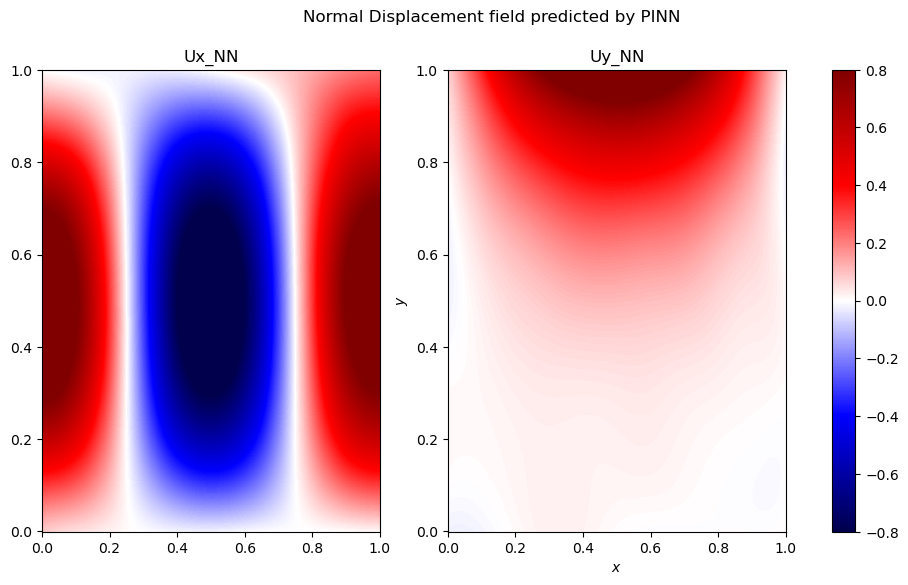

In [152]:
# Set up meshgrid
N = 1000
xspace = np.linspace(lb[0], ub[0], N + 1)
yspace = np.linspace(lb[1], ub[1], N + 1)
X, Y = np.meshgrid(xspace, yspace)
Xgrid = np.vstack([X.flatten(),Y.flatten()]).T

# Determine predictions of u(t, x)
Ux_pred, Uy_pred, Sxx_pred, Syy_pred, Sxy_pred = PINN(tf.cast(Xgrid,DTYPE))
ux_pred = Ux_pred
uy_pred = Uy_pred 

# Reshape upred
Ux = ux_pred.numpy().reshape(N+1,N+1)
Uy = uy_pred.numpy().reshape(N+1,N+1)

U_total = [Ux, Uy]
U_total_name = ['Ux_NN', 'Uy_NN']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, U_total[i], cmap='seismic', vmin=-0.8, vmax=0.8)
    ax.set_title(U_total_name[i])

fig.colorbar(im, ax=axes.ravel().tolist())
plt.suptitle('Normal Displacement field predicted by PINN', fontsize=12)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

### Plot error map

1. **For Displacement predictions**

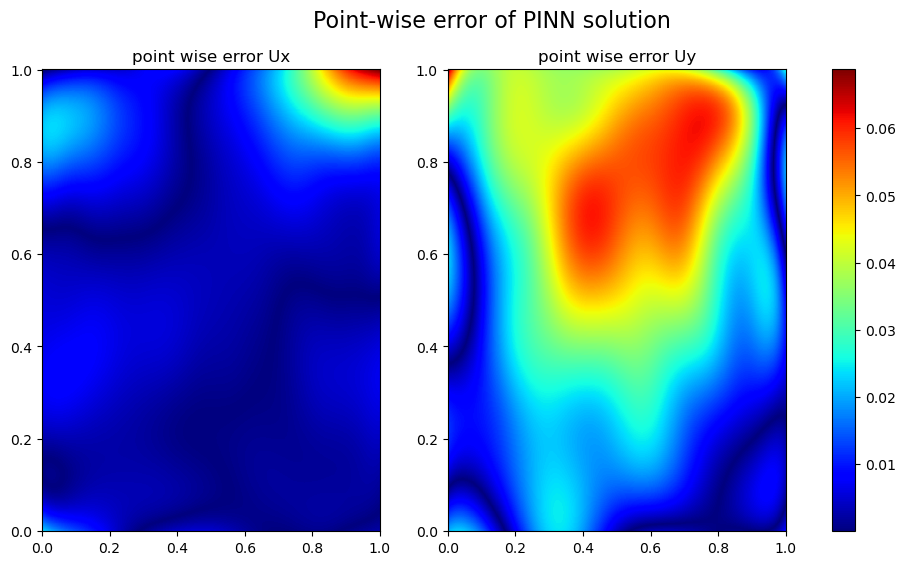

In [153]:
# calculate exact solutions
ux_ext = u_x_exact(X.flatten(),Y.flatten())
uy_ext = u_y_exact(X.flatten(),Y.flatten())

# Reshape upred
Ux_ext = ux_ext.numpy().reshape(N+1,N+1)
Uy_ext = uy_ext.numpy().reshape(N+1,N+1)

# fig.tight_layout()
# plt.show()
error_total = [abs(Ux-Ux_ext), abs(Uy-Uy_ext)]
error_total_name = ['point wise error Ux', 'point wise error Uy']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, error_total[i], cmap='jet')
    ax.set_title(error_total_name[i])

fig.colorbar(im, ax=axes.ravel().tolist())
plt.suptitle('Point-wise error of PINN solution', fontsize=16)
plt.show()

2. **For Stress tensors**

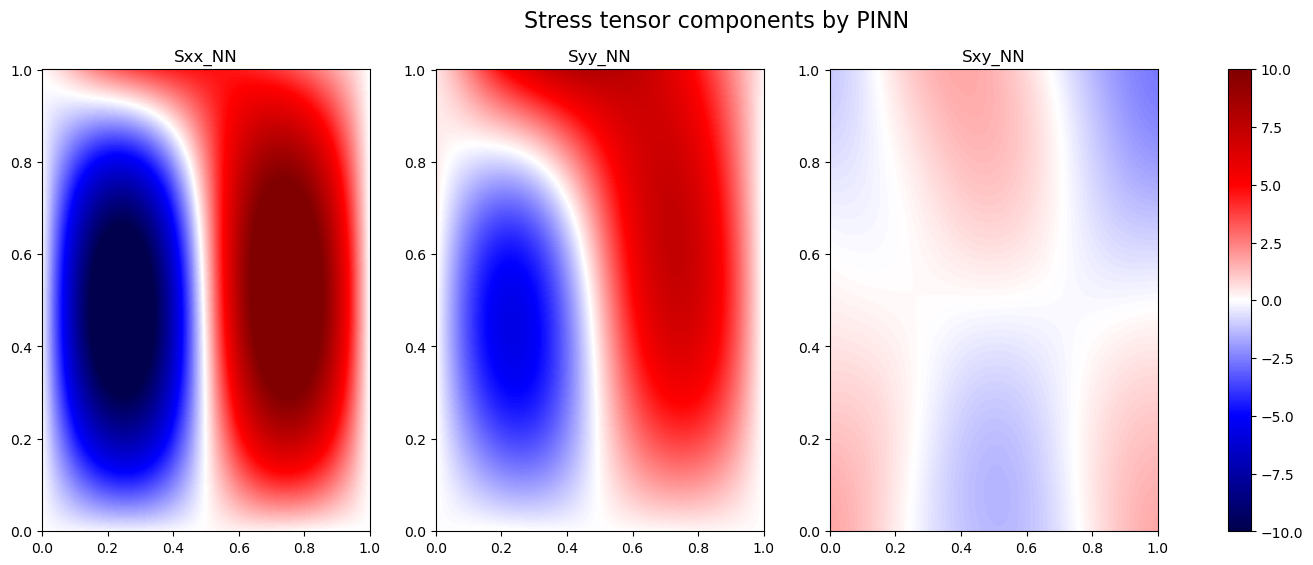

In [154]:
# Determine predictions of stress tensor components
# Note: The stress tensor components are derived from the displacements using the constitutive relations.
Ux_pred, Uy_pred, Sxx_pred, Syy_pred, Sxy_pred = PINN(tf.cast(Xgrid,DTYPE))
sxx_pred = Sxx_pred
syy_pred = Syy_pred
sxy_pred = Sxy_pred

# Reshape upred
Sxx = sxx_pred.numpy().reshape(N+1,N+1)
Syy = syy_pred.numpy().reshape(N+1,N+1)
Sxy = sxy_pred.numpy().reshape(N+1,N+1)

S_total = [Sxx, Syy, Sxy]
S_total_name = ['Sxx_NN', 'Syy_NN', 'Sxy_NN']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, S_total[i], cmap='seismic', vmin=-10, vmax=10)
    ax.set_title(S_total_name[i])

fig.colorbar(im, ax=axes.ravel().tolist())
plt.suptitle('Stress tensor components by PINN', fontsize=16)
plt.show()

#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

In [155]:
# import pickle
# filename = 'solidmechanics_model_stack.sav'
# pickle.dump(PINN, open(filename, 'wb'))

In [156]:
PINN.summary()

Model: "model_86"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_87 (InputLayer)       [(None, 2)]                  0         []                            
                                                                                                  
 lambda_86 (Lambda)          (None, 2)                    0         ['input_87[0][0]']            
                                                                                                  
 dense_1108 (Dense)          (None, 15)                   45        ['lambda_86[0][0]']           
                                                                                                  
 dropout_678 (Dropout)       (None, 15)                   0         ['dense_1108[0][0]']          
                                                                                           

In [157]:
PINN.compiled_metrics == None

True

# Contour Plots

1. Displacements

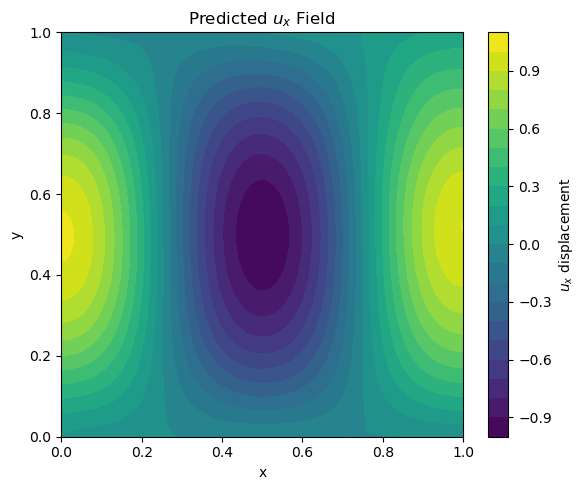

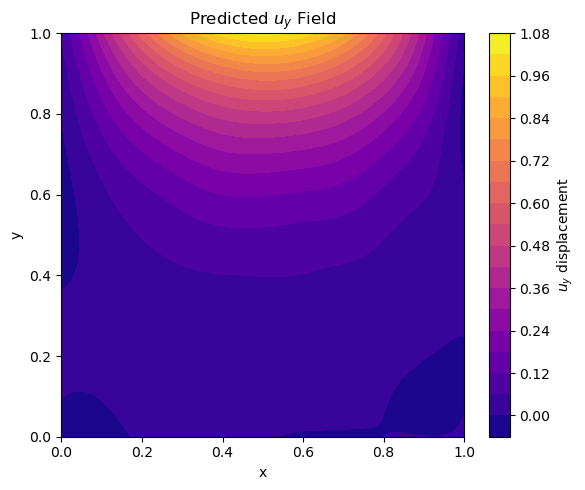

In [158]:
import matplotlib.pyplot as plt

# Ux displacement
plt.figure(figsize=(6,5))
plt.tricontourf(Xgrid[:,0], Xgrid[:,1], Ux_pred.numpy().flatten(), 20, cmap='viridis')
plt.colorbar(label='$u_x$ displacement')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted $u_x$ Field')
plt.tight_layout()
plt.show()

# Uy displacement
plt.figure(figsize=(6,5))
plt.tricontourf(Xgrid[:,0], Xgrid[:,1], Uy_pred.numpy().flatten(), 20, cmap='plasma')
plt.colorbar(label='$u_y$ displacement')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted $u_y$ Field')
plt.tight_layout()
plt.show()

2. Stress fields

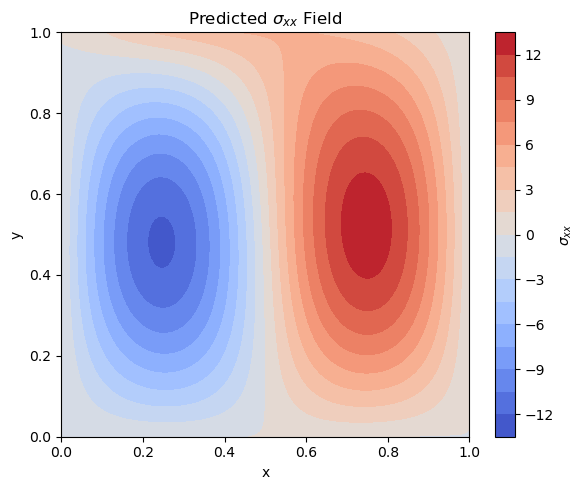

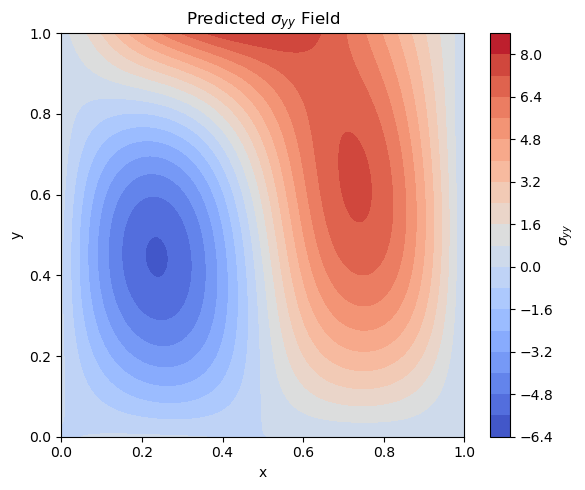

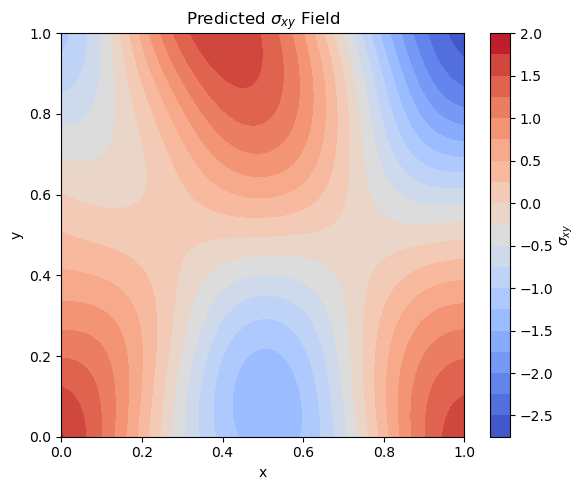

In [159]:
# Sxx stress
plt.figure(figsize=(6,5))
plt.tricontourf(Xgrid[:,0], Xgrid[:,1], Sxx_pred.numpy().flatten(), 20, cmap='coolwarm')
plt.colorbar(label='$\sigma_{xx}$')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted $\sigma_{xx}$ Field')
plt.tight_layout()
plt.show()

# Syy stress
plt.figure(figsize=(6,5))
plt.tricontourf(Xgrid[:,0], Xgrid[:,1], Syy_pred.numpy().flatten(), 20, cmap='coolwarm')
plt.colorbar(label='$\sigma_{yy}$')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted $\sigma_{yy}$ Field')
plt.tight_layout()
plt.show()

# Sxy stress
plt.figure(figsize=(6,5))
plt.tricontourf(Xgrid[:,0], Xgrid[:,1], Sxy_pred.numpy().flatten(), 20, cmap='coolwarm')
plt.colorbar(label='$\sigma_{xy}$')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted $\sigma_{xy}$ Field')
plt.tight_layout()
plt.show()


### Plot the evolution of loss

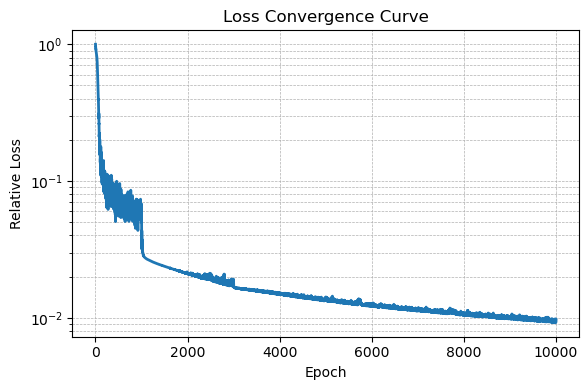

In [160]:
plt.figure(figsize=(6,4))
plt.plot(hist, lw=2)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Relative Loss')
plt.title('Loss Convergence Curve')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

# Visualization of the Residuals

1. **PDE (Equilibrium Residuals) Residuals**

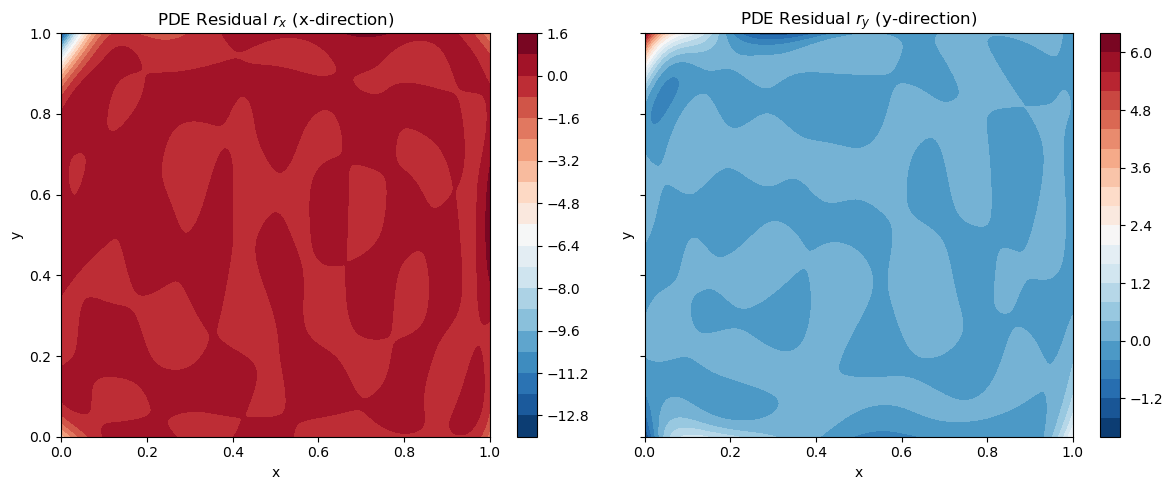

In [161]:
import matplotlib.pyplot as plt

# Compute equilibrium residuals across your grid
rx_grid, ry_grid = get_eq_r(PINN, Xgrid)

# Convert to numpy arrays (if not already)
rx_plot = rx_grid.numpy().flatten()
ry_plot = ry_grid.numpy().flatten()

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

c1 = axes[0].tricontourf(Xgrid[:,0], Xgrid[:,1], rx_plot, 20, cmap='RdBu_r')
fig.colorbar(c1, ax=axes[0])
axes[0].set_title(r'PDE Residual $r_x$ (x-direction)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

c2 = axes[1].tricontourf(Xgrid[:,0], Xgrid[:,1], ry_plot, 20, cmap='RdBu_r')
fig.colorbar(c2, ax=axes[1])
axes[1].set_title(r'PDE Residual $r_y$ (y-direction)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

plt.tight_layout()
plt.show()

2. **Constitutive Residuals**

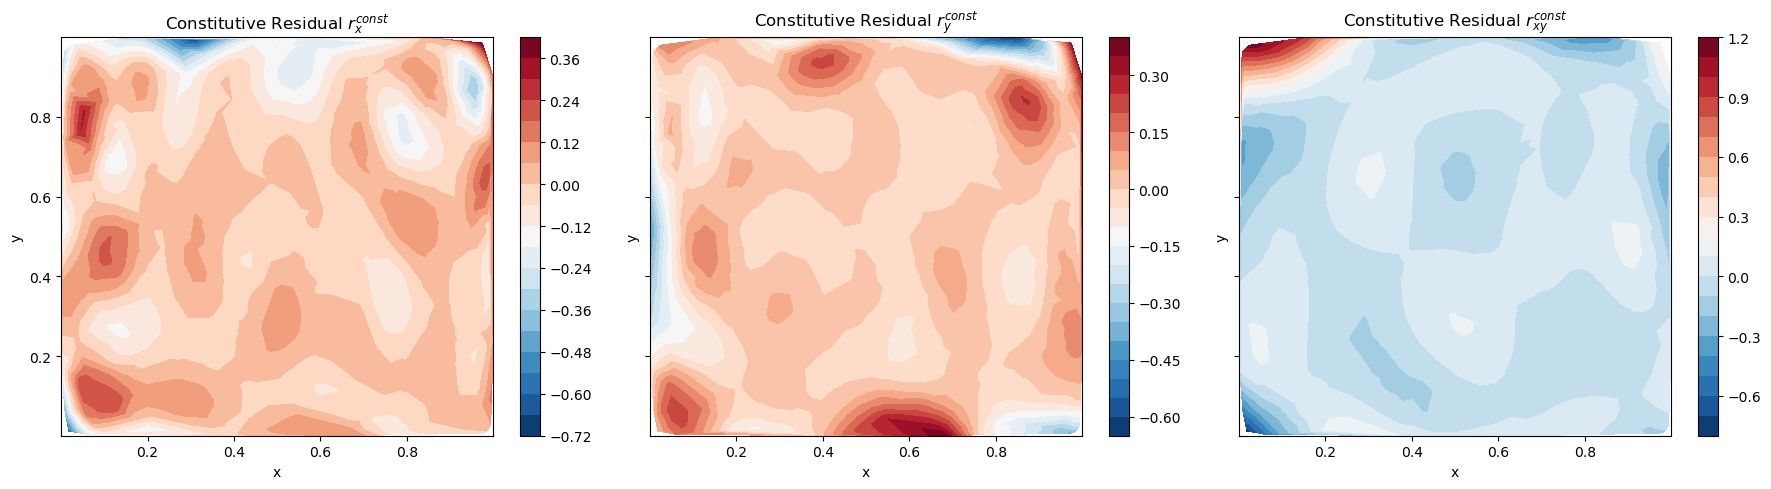

In [162]:
# Compute constitutive residuals at collocation points
rx_const, ry_const, rxy_const = get_consti_r(PINN, Residual_train)

# Flatten arrays for plotting
rx_const_plot = rx_const.numpy().flatten()
ry_const_plot = ry_const.numpy().flatten()
rxy_const_plot = rxy_const.numpy().flatten()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

c1 = axes[0].tricontourf(Residual_train[:,0], Residual_train[:,1], rx_const_plot, 20, cmap='RdBu_r')
fig.colorbar(c1, ax=axes[0])
axes[0].set_title(r'Constitutive Residual $r^{const}_x$')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

c2 = axes[1].tricontourf(Residual_train[:,0], Residual_train[:,1], ry_const_plot, 20, cmap='RdBu_r')
fig.colorbar(c2, ax=axes[1])
axes[1].set_title(r'Constitutive Residual $r^{const}_y$')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

c3 = axes[2].tricontourf(Residual_train[:,0], Residual_train[:,1], rxy_const_plot, 20, cmap='RdBu_r')
fig.colorbar(c3, ax=axes[2])
axes[2].set_title(r'Constitutive Residual $r^{const}_{xy}$')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')

plt.tight_layout()
plt.show()

3. **Dirichlet Boundary condition**

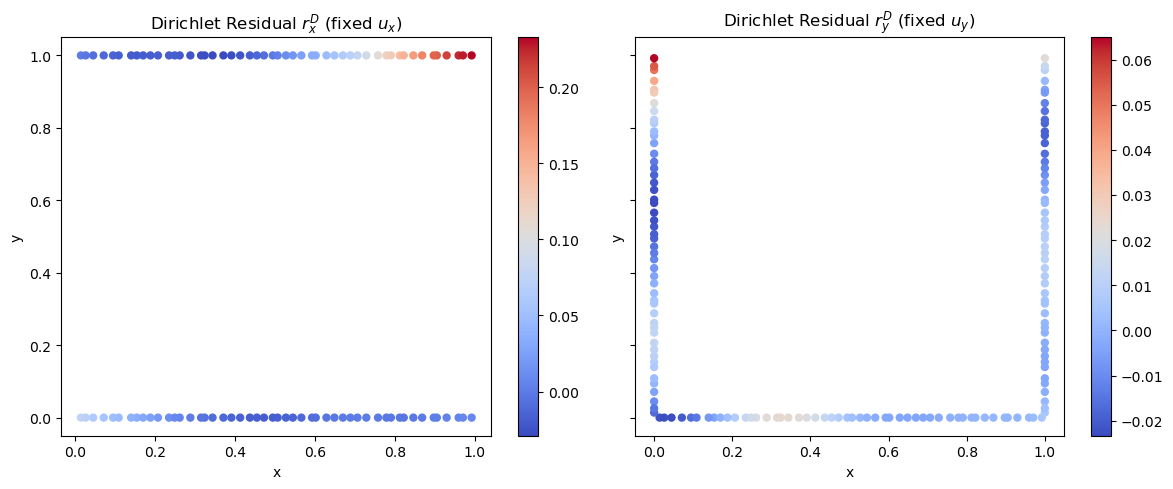

In [163]:
# --- 1. Compute Dirichlet Residuals ---
r_ux, r_uy = get_Dirichlet_r(PINN, Boundary_list, Dirichlet_x_train, Dirichlet_y_train)

# --- 2. Concatenate Boundary Coordinates ---
import numpy as np

x_up_train, x_lo_train, x_ri_train, x_le_train = Boundary_list

# For r_ux: top and bottom boundaries
X_bc_x = np.concatenate([x_up_train, x_lo_train], axis=0)  # shape (N1+N2, 2)

# For r_uy: bottom, right, left boundaries
X_bc_y = np.concatenate([x_lo_train, x_ri_train, x_le_train], axis=0)  # shape (N3+N4+N5, 2)

# --- 3. Plot Dirichlet Residuals ---
import matplotlib.pyplot as plt

# Flatten if needed
r_ux_plot = r_ux.numpy().flatten()
r_uy_plot = r_uy.numpy().flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# X-displacement residuals (Dirichlet)
c1 = axes[0].scatter(X_bc_x[:,0], X_bc_x[:,1], c=r_ux_plot, cmap='coolwarm', s=25)
fig.colorbar(c1, ax=axes[0])
axes[0].set_title(r'Dirichlet Residual $r^D_x$ (fixed $u_x$)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Y-displacement residuals (Dirichlet)
c2 = axes[1].scatter(X_bc_y[:,0], X_bc_y[:,1], c=r_uy_plot, cmap='coolwarm', s=25)
fig.colorbar(c2, ax=axes[1])
axes[1].set_title(r'Dirichlet Residual $r^D_y$ (fixed $u_y$)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

plt.tight_layout()
plt.show()

4. **Neumann Boundary Conditions**

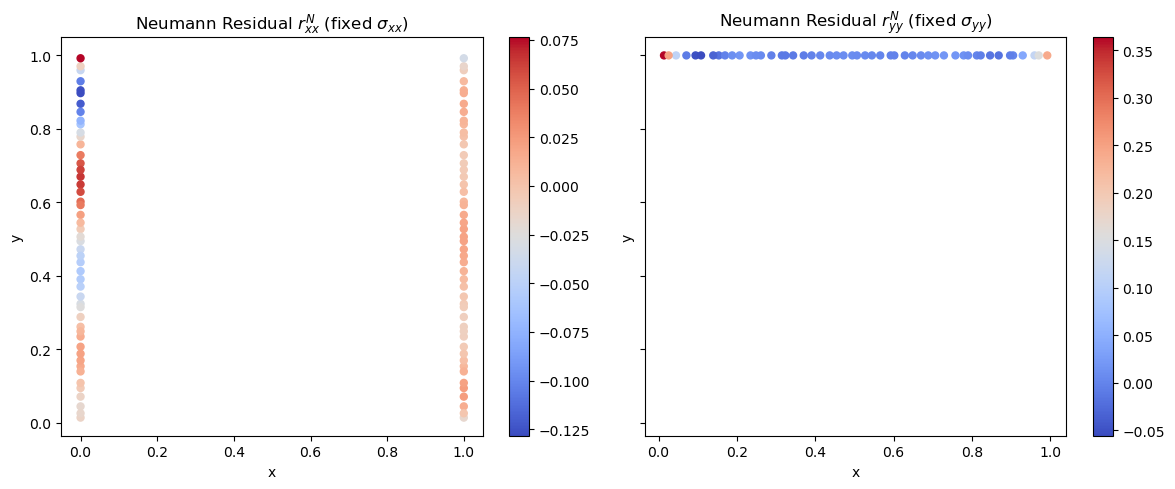

In [164]:
# --- 1. Compute Neumann Residuals ---
r_Sxx, r_Syy = get_Neumann_r(PINN, Boundary_list, Neumann_xx_train, Neumann_yy_train)

# --- 2. Prepare Corresponding Boundary Coordinates ---
import numpy as np

x_up_train, x_lo_train, x_ri_train, x_le_train = Boundary_list

# Sxx BC residuals: right and left boundaries
X_bc_Sxx = np.concatenate([x_ri_train, x_le_train], axis=0)

# Syy BC residuals: upper boundary
X_bc_Syy = x_up_train  # already the correct shape

# --- 3. Plot Neumann Residuals ---
import matplotlib.pyplot as plt

r_Sxx_plot = r_Sxx.numpy().flatten()
r_Syy_plot = r_Syy.numpy().flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Sxx boundary residuals (Neumann)
c1 = axes[0].scatter(X_bc_Sxx[:,0], X_bc_Sxx[:,1], c=r_Sxx_plot, cmap='coolwarm', s=25)
fig.colorbar(c1, ax=axes[0])
axes[0].set_title(r'Neumann Residual $r^N_{xx}$ (fixed $\sigma_{xx}$)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Syy boundary residuals (Neumann)
c2 = axes[1].scatter(X_bc_Syy[:,0], X_bc_Syy[:,1], c=r_Syy_plot, cmap='coolwarm', s=25)
fig.colorbar(c2, ax=axes[1])
axes[1].set_title(r'Neumann Residual $r^N_{yy}$ (fixed $\sigma_{yy}$)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

plt.tight_layout()
plt.show()

# Hyperparameters Tuning

In [165]:
print("----- PINN Model Hyperparameters -----")
print(f"Hidden layers: {num_hidden_layers}")
print(f"Neurons per layer: {num_neurons_per_layer}")
print(f"Activation function: tanh")
print(f"Dropout rate: 0.2")
print(f"Kernel initializer: glorot_normal")
print(f"Learning rate schedule: 0-1000 steps: 0.01, 1000-3000: 0.001, 3000+: 0.0005")
print(f"Optimizer: Adam")
print(f"Epochs: {N}")
print("---------------------------------------")

----- PINN Model Hyperparameters -----
Hidden layers: 6
Neurons per layer: 15
Activation function: tanh
Dropout rate: 0.2
Kernel initializer: glorot_normal
Learning rate schedule: 0-1000 steps: 0.01, 1000-3000: 0.001, 3000+: 0.0005
Optimizer: Adam
Epochs: 1000
---------------------------------------


1. **Data Splitting**

**Reload the original whole arrays**

In [166]:
Residual_train_orig = np.array(Residual_train)
Boundary_list_orig = [np.array(x) for x in Boundary_list]

Dirichlet_up_orig = np.array(Dirichlet_up_train)
Dirichlet_x_low_orig = np.array(Dirichlet_x_low_train)
Dirichlet_y_low_orig = np.array(Dirichlet_y_low_train)
Dirichlet_right_orig = np.array(Dirichlet_right_train)
Dirichlet_left_orig = np.array(Dirichlet_left_train)
Neumann_right_orig = np.array(Neumann_right_train)
Neumann_left_orig = np.array(Neumann_left_train)
Neumann_up_orig = np.array(Neumann_up_train)

a. ***Converint to Numpy array for using train-test split***

In [167]:
from sklearn.model_selection import train_test_split
import numpy as np
# --------------- SPLIT (always from *_full arrays) -----------------------
Residual_train, Residual_val = train_test_split(Residual_train_orig, test_size=0.2, random_state=42)

# Split boundary coordinates
x_up_orig, x_lo_orig, x_ri_orig, x_le_orig = Boundary_list_orig
x_up_train, x_up_val = train_test_split(x_up_orig, test_size=0.2, random_state=42)
x_lo_train, x_lo_val = train_test_split(x_lo_orig, test_size=0.2, random_state=42)
x_ri_train, x_ri_val = train_test_split(x_ri_orig, test_size=0.2, random_state=42)
x_le_train, x_le_val = train_test_split(x_le_orig, test_size=0.2, random_state=42)

Boundary_list_train = [x_up_train, x_lo_train, x_ri_train, x_le_train]
Boundary_list_val   = [x_up_val,  x_lo_val,  x_ri_val,  x_le_val]

# Dirichlet_x: up + x_low
Dirichlet_up_train, Dirichlet_up_val = train_test_split(Dirichlet_up_orig, test_size=0.2, random_state=42)
Dirichlet_x_low_train, Dirichlet_x_low_val = train_test_split(Dirichlet_x_low_orig, test_size=0.2, random_state=42)
Dirichlet_x_train = np.concatenate([Dirichlet_up_train, Dirichlet_x_low_train], axis=0)
Dirichlet_x_val   = np.concatenate([Dirichlet_up_val, Dirichlet_x_low_val], axis=0)

# Dirichlet_y: y_low + right + left
Dirichlet_y_low_train, Dirichlet_y_low_val = train_test_split(Dirichlet_y_low_orig, test_size=0.2, random_state=42)
Dirichlet_right_train, Dirichlet_right_val = train_test_split(Dirichlet_right_orig, test_size=0.2, random_state=42)
Dirichlet_left_train, Dirichlet_left_val = train_test_split(Dirichlet_left_orig, test_size=0.2, random_state=42)
Dirichlet_y_train = np.concatenate([Dirichlet_y_low_train, Dirichlet_right_train, Dirichlet_left_train], axis=0)
Dirichlet_y_val   = np.concatenate([Dirichlet_y_low_val,   Dirichlet_right_val,   Dirichlet_left_val], axis=0)

# Neumann_xx: right + left
Neumann_right_train, Neumann_right_val = train_test_split(Neumann_right_orig, test_size=0.2, random_state=42)
Neumann_left_train, Neumann_left_val = train_test_split(Neumann_left_orig, test_size=0.2, random_state=42)
Neumann_xx_train = np.concatenate([Neumann_right_train, Neumann_left_train], axis=0)
Neumann_xx_val   = np.concatenate([Neumann_right_val,   Neumann_left_val], axis=0)

# Neumann_yy: up
Neumann_up_train, Neumann_up_val = train_test_split(Neumann_up_orig, test_size=0.2, random_state=42)
Neumann_yy_train = Neumann_up_train
Neumann_yy_val   = Neumann_up_val

# -------------- Print for sanity check --------------
print("Residual_train shape:", Residual_train.shape)
print("Dirichlet_x_train shape:", Dirichlet_x_train.shape)
print("Dirichlet_y_train shape:", Dirichlet_y_train.shape)
print("Neumann_xx_train shape:", Neumann_xx_train.shape)
print("Neumann_yy_train shape:", Neumann_yy_train.shape)

Residual_train shape: (800, 2)
Dirichlet_x_train shape: (80, 1)
Dirichlet_y_train shape: (120, 1)
Neumann_xx_train shape: (80, 1)
Neumann_yy_train shape: (40, 1)


In [168]:
import tensorflow as tf
import numpy as np

def to_tensor_safe(arr):
    """Convert arr to tf.Tensor only if it's not already a tensor."""
    if isinstance(arr, tf.Tensor):
        return arr
    return tf.constant(arr, dtype=tf.float64)

def to_tensor_list_safe(arr_list):
    return [to_tensor_safe(arr) for arr in arr_list]

b. ***Return to Tensors for model training***

In [169]:
# --- Dirichlet/Neumann BCs (all are now correct shape after your split block!) ---
Dirichlet_x_train = to_tensor_safe(Dirichlet_x_train)
Dirichlet_x_val = to_tensor_safe(Dirichlet_x_val)
Dirichlet_y_train = to_tensor_safe(Dirichlet_y_train)
Dirichlet_y_val = to_tensor_safe(Dirichlet_y_val)
Neumann_xx_train = to_tensor_safe(Neumann_xx_train)
Neumann_xx_val = to_tensor_safe(Neumann_xx_val)
Neumann_yy_train = to_tensor_safe(Neumann_yy_train)
Neumann_yy_val = to_tensor_safe(Neumann_yy_val)

# --- Boundary points (if you use per-side for PINN prediction/BC enforcement) ---
# (You'll need to split/define Boundary_list_train and Boundary_list_val per-side, just like BCs above, if using.)
# Example usage if you have: x_up_train, x_lo_train, x_ri_train, x_le_train
# Boundary_list_train = to_tensor_list_safe([x_up_train, x_lo_train, x_ri_train, x_le_train])
# Boundary_list_val = to_tensor_list_safe([x_up_val, x_lo_val, x_ri_val, x_le_val])

print("Tensors ready! (Shapes):")
print("Residual_train:", Residual_train.shape)
print("Dirichlet_x_train:", Dirichlet_x_train.shape)
print("Dirichlet_y_train:", Dirichlet_y_train.shape)
print("Neumann_xx_train:", Neumann_xx_train.shape)
print("Neumann_yy_train:", Neumann_yy_train.shape)

Tensors ready! (Shapes):
Residual_train: (800, 2)
Dirichlet_x_train: (80, 1)
Dirichlet_y_train: (120, 1)
Neumann_xx_train: (80, 1)
Neumann_yy_train: (40, 1)


2. **Adapted Model training Function for validation loss**

In [170]:
import tensorflow as tf
import numpy as np
from time import time

def build_and_train_pinn(num_hidden_layers, num_neurons_per_layer, dropout_rate, kernel_initializer, epochs):
    # Build model
    input_layer = tf.keras.Input(shape=(2,))
    scaling_layer = tf.keras.layers.Lambda(lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    x = scaling_layer(input_layer)
    for _ in range(num_hidden_layers):
        x = tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'),
                                 kernel_initializer=kernel_initializer)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    output_Ux = tf.keras.layers.Dense(1)(x)
    output_Uy = tf.keras.layers.Dense(1)(x)
    output_Sxx = tf.keras.layers.Dense(1)(x)
    output_Syy = tf.keras.layers.Dense(1)(x)
    output_Sxy = tf.keras.layers.Dense(1)(x)
    PINN = tf.keras.models.Model(inputs=input_layer, outputs=[output_Ux, output_Uy, output_Sxx, output_Syy, output_Sxy])

    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    
    # Training loop
    @tf.function
    def train_step():
        loss, grad_theta = get_grad(
            PINN, Residual_train, Boundary_list_train,
            Dirichlet_x_train, Dirichlet_y_train, Neumann_xx_train, Neumann_yy_train)
        optim.apply_gradients(zip(grad_theta, PINN.trainable_variables))
        return loss

    N = epochs
    hist = []
    t0 = time()
    for i in range(N+1):
        loss = train_step()
        if i==0:
            loss0 = loss
        hist.append(loss.numpy()/loss0.numpy())
    # Compute final **validation loss**:
    val_loss, _ = get_grad(
        PINN, Residual_val, Boundary_list_val,
        Dirichlet_x_val, Dirichlet_y_val, Neumann_xx_val, Neumann_yy_val)
    val_loss_value = val_loss.numpy()
    print(f'Finished {N} epochs in {time()-t0:.1f} sec. Final val loss: {val_loss_value:.4e}')
    return val_loss_value

3. **Bayesian Optimization**

Trying config: {'num_hidden_layers': 6, 'num_neurons_per_layer': 15, 'dropout_rate': 0.1, 'kernel_initializer': 'glorot_normal', 'epochs': 1000}
Finished 1000 epochs in 30.2 sec. Final val loss: 3.6668e+00
Trying config: {'num_hidden_layers': 6, 'num_neurons_per_layer': 15, 'dropout_rate': 0.2, 'kernel_initializer': 'glorot_normal', 'epochs': 1000}
Finished 1000 epochs in 28.1 sec. Final val loss: 3.5120e+00
Trying config: {'num_hidden_layers': 6, 'num_neurons_per_layer': 15, 'dropout_rate': 0.3, 'kernel_initializer': 'glorot_normal', 'epochs': 1000}
Finished 1000 epochs in 39.1 sec. Final val loss: 2.2175e+00
Trying config: {'num_hidden_layers': 6, 'num_neurons_per_layer': 20, 'dropout_rate': 0.1, 'kernel_initializer': 'glorot_normal', 'epochs': 1000}
Finished 1000 epochs in 31.6 sec. Final val loss: 4.0715e+00
Trying config: {'num_hidden_layers': 6, 'num_neurons_per_layer': 20, 'dropout_rate': 0.2, 'kernel_initializer': 'glorot_normal', 'epochs': 1000}
Finished 1000 epochs in 33.6 se

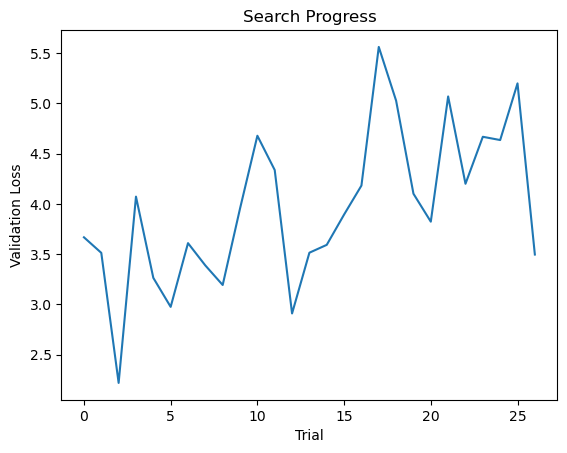

In [171]:
from itertools import product
import matplotlib.pyplot as plt

# Define your search space
search_space = {
    'num_hidden_layers': [6, 8, 10],
    'num_neurons_per_layer': [15, 20, 25],
    'dropout_rate': [0.1, 0.2, 0.3],
    'kernel_initializer': ['glorot_normal'],
    'epochs': [1000],
}

# Create a list of all combinations
keys = list(search_space.keys())
combinations = list(product(*[search_space[k] for k in keys]))

# Store results
results = []
param_list = []

# Evaluate all combinations
for params in combinations:
    config = dict(zip(keys, params))
    print(f"Trying config: {config}")
    val_loss = build_and_train_pinn(**config)
    results.append(val_loss)
    param_list.append(config)

# Find the best result
best_index = results.index(min(results))
best_config = param_list[best_index]

print("\nBest score (validation loss):", results[best_index])
print("Best parameters:")
for k, v in best_config.items():
    print(f"{k}: {v}")

# Plot convergence
plt.plot(results)
plt.xlabel('Trial')
plt.ylabel('Validation Loss')
plt.title('Search Progress')
plt.show()

## Class implementation of PINNs

In this section (in future work) I implement PINNs as a class which can be used for further testing. the class `PINN_NeuralNet` from `tf.keras.Model` is in mind.

Required arguments are the lower bound `lb` and upper bound `ub`.